# Fauno an Italian LLM

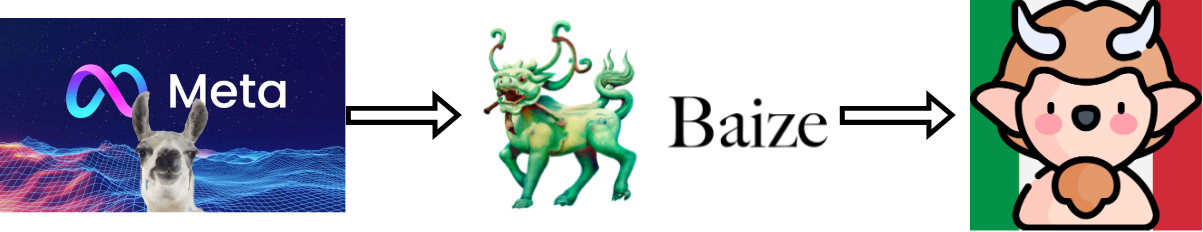

## Requirements

In [1]:
! pip3 install datasets==2.11.0 loralib sentencepiece git+https://github.com/huggingface/transformers.git accelerate==0.20.3 bitsandbytes==0.37.2 git+https://github.com/huggingface/peft.git gradio appdirs

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-qebagc65
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-qebagc65
  Resolved https://github.com/huggingface/transformers.git to commit d27e4c18fe2970abcb9a48dcb8a824e48083b15f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/huggingface/peft.git to /tmp/pip-req-build-n47g8y35
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/peft.git /tmp/pip-req-build-n47g8y35
  Resolved https://github.com/huggingface/peft.git to commit b10a8cedf612e3994dc67fe8dad2a40c9076bcd4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━

In [2]:
from typing import *
import torch
import transformers

# Model setup

In [3]:
from transformers import LlamaTokenizer, LlamaForCausalLM, GenerationConfig
from peft import PeftModel

tokenizer = LlamaTokenizer.from_pretrained("decapoda-research/llama-7b-hf")
model = LlamaForCausalLM.from_pretrained(
    "decapoda-research/llama-7b-hf",
    load_in_8bit=True,
    device_map="auto",
)
model = PeftModel.from_pretrained(model, "andreabac3/Fauno-Italian-LLM-7B")
model.eval()


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching /usr/local/cuda/lib64...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 7.5
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cuda118.so...


/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: /usr/lib64-nvidia did not contain libcudart.so as expected! Searching further paths...
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/sys/fs/cgroup/memory.events /var/colab/cgroup/jupyter-children/memory.events')}
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('http'), PosixPath('//172.28.0.1'), PosixPath('8013')}
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('//colab.research.google.com/tun/m/cc48301118ce562b961b3c22d803539adc1e0c19/gpu-t4-s-1yx5

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'LLaMATokenizer'. 
The class this function is called from is 'LlamaTokenizer'.
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This means that tokens that come after special tokens will not be properly handled. We recommend you to read the related pull request available at https://github.com/huggingface/transformers/pull/24565, and set the legacy attribute accordingly.


Loading checkpoint shards:   0%|          | 0/33 [00:00<?, ?it/s]

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 4096, padding_idx=31999)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): Linear8bitLt(
                in_features=4096, out_features=4096, bias=False
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): Linear8bitLt(
                in_features=4096, out_features=4096, bia

In [ ]:
def evaluate(question):
    prompt = f"La conversazione tra assistente umano e AI. \n[|Human|] {question}.\n[|AI|] "
    inputs = tokenizer(prompt, return_tensors="pt")
    input_ids = inputs["input_ids"].cuda()
    generation_output = model.generate(
        input_ids=input_ids,
        generation_config=GenerationConfig(
            temperature=1,
            top_p=0.95,
            num_beams=4,
            max_context_length_tokens=2048,
        ),
        # generation_config=GenerationConfig(
        #     temperature=0.7,
        #     top_p=0.99,
        #     num_beams=4,
        #     early_stopping=True,
        #     top_k=40,
        # ),
        return_dict_in_generate=True,
        output_scores=True,
        max_new_tokens=512
    )
    output = tokenizer.decode(generation_output.sequences[0]).split("[|AI|]")[1]
    return output

def generate_prompt_with_history(text:str,history: str,tokenizer,max_length=2048):
    prompt = "The following is a conversation between a human and an AI assistant named Fauno. Fauno is an open-source AI assistant developed by Andrea Bacciu, Giovanni Trappolini, Andrea Santilli and Professor Fabrizio Silvestri members of the RSTLess Research group from Sapienza University of Rome. The human and the AI assistant take turns chatting. Human statements start with [|Umano|] and AI assistant statements start with [|AI|]. The AI assistant always provides responses in as much detail as possible, and in Markdown format. The AI assistant always declines to engage with topics, questions and instructions related to unethical, controversial, or sensitive issues. Complete the transcript in exactly that format.\n[|Umano|]Ciao!\n[|AI|]Ciao a te!"
    history = ["\n[|Human|]{}\n[|AI|]{}".format(x[0],x[1]) for x in history]
    history.append("\n[|Human|]{}\n[|AI|]".format(text))
    history_text = ""

    for x in history[::-1]:
        if tokenizer(prompt+history_text+x, return_tensors="pt")['input_ids'].size(-1) <= max_length:
            history_text = x + history_text
            flag = True
    if flag:
        return  prompt+history_text,tokenizer(prompt+history_text, return_tensors="pt")
    else:
        return False
def is_stop_word_or_prefix(s: str, stop_words: list) -> bool:
    for stop_word in stop_words:
        if s.endswith(stop_word):
            return True
        for i in range(1, len(stop_word)):
            if s.endswith(stop_word[:i]):
                return True
    return False

# Greedy Search
def greedy_search(input_ids: torch.Tensor,
                  model: torch.nn.Module,
                  tokenizer: transformers.PreTrainedTokenizer,
                  stop_words: list,
                  max_length: int,
                  temperature: float = 1.0,
                  top_p: float = 1.0,
                  top_k: int = 25) -> Iterator[str]:
    generated_tokens = []
    past_key_values = None
    current_length = 1
    for i in range(max_length):
        with torch.no_grad():
            if past_key_values is None:
                outputs = model(input_ids)
            else:
                outputs = model(input_ids[:, -1:], past_key_values=past_key_values)
            logits = outputs.logits[:, -1, :]
            past_key_values = outputs.past_key_values

        # apply temperature
        logits /= temperature

        probs = torch.softmax(logits, dim=-1)
        # apply top_p
        probs_sort, probs_idx = torch.sort(probs, dim=-1, descending=True)
        probs_sum = torch.cumsum(probs_sort, dim=-1)
        mask = probs_sum - probs_sort > top_p
        probs_sort[mask] = 0.0

        # apply top_k
        #if top_k is not None:
        #    probs_sort1, _ = torch.topk(probs_sort, top_k)
        #    min_top_probs_sort = torch.min(probs_sort1, dim=-1, keepdim=True).values
        #    probs_sort = torch.where(probs_sort < min_top_probs_sort, torch.full_like(probs_sort, float(0.0)), probs_sort)

        probs_sort.div_(probs_sort.sum(dim=-1, keepdim=True))
        next_token = torch.multinomial(probs_sort, num_samples=1)
        next_token = torch.gather(probs_idx, -1, next_token)

        input_ids = torch.cat((input_ids, next_token), dim=-1)

        generated_tokens.append(next_token[0].item())
        text = tokenizer.decode(generated_tokens)

        yield text
        if any([x in text for x in stop_words]):
            return
@torch.no_grad()
def predict(text:str,
            chatbot,
            history:str="",
            top_p:float=0.95,
            temperature:float=1.0,
            max_length_tokens:int=512,
            max_context_length_tokens:int=2048):
    if text=="":
        return ""

    inputs = generate_prompt_with_history(text,history,tokenizer,max_length=max_context_length_tokens)
    prompt,inputs=inputs
    begin_length = len(prompt)

    input_ids = inputs["input_ids"].to(chatbot.device)
    output = []

    for x in greedy_search(input_ids,model,tokenizer,stop_words=["[|Human|]", "[|AI|]"],max_length=max_length_tokens,temperature=temperature,top_p=top_p):
        if is_stop_word_or_prefix(x,["[|Human|]", "[|AI|]"]) is False:
            if "[|Human|]" in x:
                x = x[:x.index("[|Human|]")].strip()
            elif "[| Human |]" in x:
                x = x[:x.index("[| Human |]")].strip()
            elif "[| Umano |]" in x:
                x = x[:x.index("[| Umano |]")].strip()
            elif "[|Umano|]" in x:
                x = x[:x.index("[|Umano|]")].strip()
            if "[|AI|]" in x:
                x = x[:x.index("[|AI|]")].strip()
            x = x.strip(" ")
            output.append(x)
    return output[-1]


# Chat with Fauno

In [ ]:
# @title Example 1: Programming
text = "Scrivi un programma Python3 che stampa solo numeri pari da 0 a 100" # @param {type: "string"}
print(predict(text, model))

'for num in range(0, 101):
    if num % 2 == 0:
        print(num)'


In [ ]:
# @title Example 2: General knowledge
text = "Qual è il significato della vita?" # @param {type: "string"}
print(predict(text, model))

Il significato della vita è un tema che ha intrigato la mente umana per secoli. Esistono molte teorie e idee diverse sulla questione, che va dal bella vita appagante alla vita come cammino verso qualcosa di più grandioso, o persino che non abbiamo un significato in vista.


In [ ]:
# @title Example 3: Historical knowledge
text = "Scrivi una breve biografia su Dante Alighieri" # @param {type: "string"}
print(predict(text, model))

Dante Alighieri è il poeta o leggendario del Divina Commedia, considerato il maggior autore italiano di tutti i tempi. Nacque a Firenze intorno al 1265 e morì nel 1321. Dante è conosciuto per la sua ricca poesia, la sua fedeltà ai valori morali e la sua eccellenza letteraria. È considerato un pilastro della letteratura occidentale, nonché un importante punto di riferimento nella cultura occidentale e nella lingua italiana. Anche se le opinioni e l'interpretazione della vita di Dante variano, il suo immenso impatto e il suo contributo alla letteratura sono universali. Nel 1321, Dante venne esiliato dal Regno di Firenze e visse nel nord Italia, dove completò il Divina Commedia e nel 1324, morì. È stato celebrato con diverse statue in città e paesi come Firenze, Milano, Catania e Bologna, ed è anche famoso per la sua passione per i pomodori, per questo motivo è chiamato oggi anche la "Dante della Chinotto". È stato, e rimarrà sempre, uno dei maestri più grandi di tutti i tempi. C'è qualco